Autoenconder Variacional (VAE)
----

~~~
Extracción de Características en Imágenes.
Master en Ciencia de Datos e Ingeniería de Computadores.
Universidad de Granada.

Francisco Javier Sáez Maldonado - fjaviersaezm@ugr.es
Rafael Molina Soriano - rms@decsai.ugr.es

Créditos: Francisco Miguel Castro Macías, Fernando Pérez Bueno
~~~

En este guión veremos la implementación de un Autoencoder Variacional (VAE) en Pytorch. Te dejamos algunos enlaces útiles:

- En esta publicación de towardsdatascience.com (https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf) hay una explicación muy intuitiva sobre VAEs y contiene algunos de los ejemplos que se han mencionado en clase. 
- En este enlace puedes visualizar el contenido del espacio latente de una VAE entrenada con MNIST: http://taylordenouden.com/VAE-Latent-Space-Explorer/.
- Si quieres aprender más sobre Pytorch, te recomendamos que mires este repositorio de Miguel López Pérez y Andrea Morales Garzón, en el que se explica cómo desarrollar una aplicación en Pytorch: https://github.com/wizmik12/first-app-pytorch

# Una breve introducción a las redes neuronales

Tal vez nunca antes te hayan hablado de redes neuronales. A continuación vamos a hacer un pequeño resumen de las ideas más básicas. 

Una red neuronal es una composición de funciones. En este guión vamos a trabajar con las redes neuronales más sencillas. En algunos libros las llaman "perceptrón multicapa" o "feedforward network". Se definen así:
$$ \begin{cases}
    \mathbf{x}_0 \in \mathbb{R}^{d_0}, \\ 
    \mathbf{x}_k = h\left(\mathbf{W}_k \mathbf{x}_{k-1} \right), \quad k \in \{ 1, 2, \ldots, K\},
    \end{cases}
$$
donde $\mathbf{W}_k \in \mathbb{R}^{d_{k} d_{k-1}}$ y $h \colon \mathbb{R} \to \mathbb{R}$ es una función que se aplica componente a componente. Si llamamos $f_k(\mathbf{x}) = h(\mathbf{W}_k \mathbf{x})$, tenemos que una red neuronal es la aplicación:
$$ f(\mathbf{x}; \mathbf{W}) = (f_K \circ \cdots \circ f_1)(\mathbf{x}).$$
No te asustes por la definición, es una cosa muy simple: partimos de un vector inicial $\mathbf{x}_0$, lo multiplicamos por una matriz y le aplicamos $h$. En el siguiente paso partimos del vector que hemos obtenido, y aplicamos el mismo procedimiento. Esto lo repetimos $K$ pasos.

La función $h$ se llama "función de activación". Es importante que esta función sea no lineal, ya que así la red podrá aprender funciones mucho más complejas. En este guión vamos a usar la función RELU,
$$ h(x) = \begin{cases} 
    x & \text{si} & x\geq0, \\
    0 & \text{si} & x < 0.
    \end{cases}
$$

Las matrices $\mathbf{W}_k$ son los parámetros de la red. Entrenar una red neuronal consiste en encontrar los mejores parámetros de acuerdo a algún criterio. Imagínate que estamos en un problema de regresión en el que cada ejemplo $\mathbf{x}_i$ está acompañado de una etiqueta $y_i \in \mathbb{R}$. Lo que nos gustaría es encontrar aquellos parámetros que minimicen
$$ \mathcal{L}(\mathbf{W}) = \sum_{i}(f(\mathbf{x}_i, \mathbf{W}) - y_i)^2.$$
A $\mathcal{L}$ se le llama función de pérdida. Si las funciones $h$ son diferenciables (o casi) $\mathcal{L}(\mathbf{W})$ será diferenciable y podemos emplear técnicas basadas en gradiente descendente. El gradiente descendente es un método iterativo para optimizar funciones diferenciables. Para minimizar $\mathcal{L}(\mathbf{W})$, la versión básica de gradiente descendente consiste en aplicar las actualizaciones: 
$$ \mathbf{W}_{k+1} = \mathbf{W}_k - \eta \nabla_\mathbf{W} \mathcal{L}(\mathbf{W}_k) $$

A $\eta$ se le denomina *learning rate*. Los gradientes $\nabla_\mathbf{W} \mathcal{L}(\mathbf{W}_k)$ en una red neuronal se calculan mediante técnicas de "diferenciación automática". Seguro que te suena el algoritmo "backpropagation". Estas técnicas (y la propia evaluación de redes neuronales) son costosas computacionalmente, pero altamente paralelizables. Por ello, el uso de GPUs puede agilizar enormemente el entrenamiento y la inferencia. Librerías como Pytorch y Tensorflow ofrecen una interfaz para poder entrenar redes neuronales en GPUs sin tener que preocuparnos por cómo se realiza esta paralelización a bajo nivel. Sin embargo, sí que debemos tener una idea general del procedimiento. Tanto los parámetros $\mathbf{W}$ como los ejemplos de entrenamiento deben de cargarse en la GPU. Sin embargo, las GPUs tienen una memoria limitada, por lo que (normalmente) no se pueden cargar todos los ejemplos a la vez. Lo que se suele hacer es que los ejemplos se agrupan en *batches*, los cuales se cargan y se procesan en la GPU por separado. 

En resumen, para entrenar una red neuronal necesitamos especificar:
1. La estructura de la red. 
2. La función de pérdida.

Vamos a ver que Pytorch nos permite hacer estas cosas de forma muy natural. Lo primero que hacemos es cargar todas las librerías que vamos a usar.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from tqdm import tqdm

print("Versión de Pytorch:", torch.__version__)

Versión de Pytorch: 2.5.1+cu124


Las librerías como Tensorflow y Pytorch ofrecen funcionalidades para poder entrenar nuestros modelos en tarjetas gráficas usando el software CUDA. Si hemos configurado Pytorch correctamente y CUDA tiene acceso a las tarjetas, las siguientes líneas mostrarán el nombre de la tarjeta (o tarjetas) disponibles.

In [2]:
print("CUDA:", torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE.type == "cuda":
    print("Device name: ", torch.cuda.get_device_name())

CUDA: True
Device name:  NVIDIA GeForce RTX 2050


Vamos a fijar el tamaño de batch y el número de épocas que entrenaremos la red.

In [3]:
BATCH_SIZE = 128
EPOCHS = 30

# Conjunto de datos: MNIST

El conjunto de datos de caras que venimos utilizando se nos queda un poco pequeño para entrenar una red neuronal. Además, comprenderemos mucho mejor la estructura del espacio latente de un Autoencoder si usamos datos que tengan distintas etiquetas. En esta ocasión vamos a trabajar con el conjunto MNIST, que probablemente ya conozcas. Se trata de imágenes 28x28 de números manuscritos, con un total de 70.000 muestras.

`torchvision` ofrece distintos conjuntos que podemos usar con una sóla línea. MNIST es uno de ellos:

In [4]:
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=torchvision.transforms.ToTensor())
print(dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


Como vemos, el conjunto MNIST tiene 60.000 ejemplos. Vamos a ver qué formato tiene un ejemplo:

In [5]:
img, label = dataset[2]
print("Number of images:", len(dataset))
print("img:", img.shape)
print("max:", img.max(), "min:", img.min())
print("label:", label)

Number of images: 60000
img: torch.Size([1, 28, 28])
max: tensor(1.) min: tensor(0.)
label: 4


Son imágenes de un sólo canal (escala de grises) y dimensiones 28x28. Además, todos los ejemplos se encuentran normalizados. Vamos a inspeccionar 8 ejemplos aleatorios.

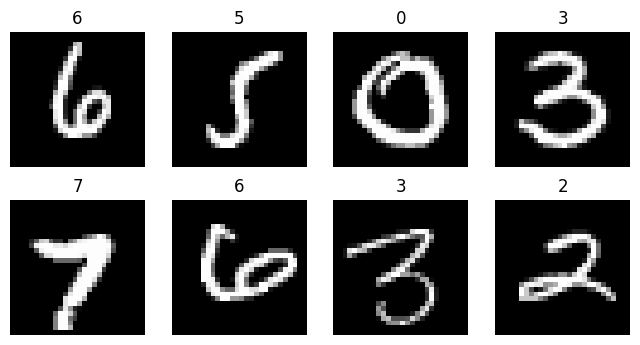

In [6]:
figure = plt.figure(figsize=(8, 4))
cols, rows = 4, 2
for i in range(1, cols * rows + 1):
    idx = np.random.randint(0, len(dataset))
    img, label = dataset[idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

El objeto `DataLoader` de Pytorch nos permite recorrer un dataset de forma eficiente, dividiéndolo automáticamente en batches. 

In [7]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Autoencoder determinista

Lo primero que vamos a hacer es construir un autoencoder determinista. Primero vamos a repasar qué es. Como sabéis, un Autoencoder tiene dos partes: un codificador (Encoder) y un decodificador (Decoder). Vamos a denotar el espacio de entrada por $\mathcal{X} \subset \mathbb{R}^D$ y el espacio latente por $\mathcal{Z} \subset \mathbb{R}^d$. 

Podemos entender el Encoder como una aplicación $f_E \colon \mathcal{X} \to \mathcal{Z}$ y el Decoder como una aplicación $f_D \colon \mathcal{Z} \to \mathcal{X}$. El Autoencoder es entonces la composición de ambas, $f = f_D \circ f_E \colon \mathcal{X} \to \mathcal{X}$.

Para definir una red en Pytorch debemos crear una clase que herede de `torch.nn.Module`. Podemos entender que un modelo en Pytorch implementa una función $g$, y el método `forward(x)` se corresponde con $g(x)$. 

In [8]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=28 * 28, out_features=100),  # [B, 100]
            torch.nn.ReLU(),  # [B, 100]
            torch.nn.Linear(in_features=100, out_features=50),  # [B, 50]
            torch.nn.ReLU(),  # [B, 50]
            torch.nn.Linear(in_features=50, out_features=latent_dim),  # [B, latent_dim]
        )

    def forward(self, x):  # x: [B, 1, 28, 28]
        x = x.view(x.size(0), -1)  # [B, 1*28*28]
        z = self.encoder(x)  # z: [B, latent_dim]
        return z

> 📝 **Pregunta 1 (1 punto).** ¿Qué pasaría en el espacio latente si aplicamos una RELU a la salida del codificador?

> **Respuesta**: La RELU es cero para valores negativos, por lo que se perdería información de todas las entradas negativas. Por ello lo que ocurriría sería una pérdida de información.

Ahora construimos el decodificador. 

In [9]:
class Decoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=latent_dim, out_features=50),  # [B, 50]
            torch.nn.ReLU(),  # [B, 50]
            torch.nn.Linear(in_features=50, out_features=100),  # [B, 100]
            torch.nn.ReLU(),  # [B, 100]
            torch.nn.Linear(in_features=100, out_features=28 * 28),  # [B, 28*28]
            torch.nn.Sigmoid(),  # [B, 28*28]
        )

    def forward(self, z):  # z: [B, latent_dim]
        x_rec = self.decoder(z)  # x_rec: [B, 1*28*28]
        # x_rec = self.decoder(z) # x_rec: [B, 1, 28, 28]
        x_rec = x_rec.view(x_rec.size(0), 1, 28, 28)  # x_rec: [B, 1, 28, 28]
        return x_rec

> 📝 **Pregunta 2 (1 punto).** ¿Por qué hemos usado en la última capa del decodificador una función sigmoide?

> **Respuesta**: Por que sirve para transformar los *logits* (que son *scores* no normalizados) en probabilidades. Con ello la salida es interpretable como una distribución de probabilidad para cada una de las clases que tengamos en el problema.

Y el Autoencoder, que dentro tiene el Encoder y el Decoder.

In [10]:
class Autoencoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):  # x: [B, 1, 28, 28]
        z = self.encoder(x)  # z: [B, latent_dim]
        x_rec = self.decoder(z)  # x_rec: [B, 1, 28, 28]
        return x_rec

¿Qué función de error tenemos que usar? Lo que nos gustaría que pasara es que el Autoencoder reconstruyera cualquier ejemplo a la perfección, es decir, que $f(\mathbf{x})=\mathbf{x}$. Esto es equivalente a que $\| f(\mathbf{x}) - \mathbf{x} \|^2 = 0$. Lo que queremos entonces es minimizar la diferencia entre la imagen original y la salida del Autoencoder:
$$ \mathcal{L}_{\mathrm{MSE}} = \sum_{i} \| \mathbf{x}_i - f(\mathbf{x}_i)\|^2 $$

> 📝 **Pregunta 3 (1 punto).** ¿Qué forma deben tener $f_E(\mathbf{x})$ y $f_D(\mathbf{z})$ para recuperar PCA al minimizar la función anterior?

> **Respuesta**: El codificador debería ser de la forma $f_E(\mathbf{x})=W\mathbf{x}$, donde $W$ es una matriz que transforma los datos originales al espacio latente. La forma de $f_D(\mathbf{z})=W^T\mathbf{z}$, donde de la misma forma, $W_T$ es la matriz anterior traspuesta. Es importante que tanto el codificador como el decodificador no tuviesen ninguna función de activación no lineal para garantizar que solo son transformaciones lineales, como el  **PCA**.

In [11]:
def mse_loss_fn(x, x_rec):  # x: [B, 1, 28, 28], x_rec: [B, 1, 28, 28]
    return torch.nn.functional.mse_loss(x, x_rec, reduction="sum")

La función `train_ae` implementa un bucle de entrenamiento típico de Pytorch. Fíjate que usamos la librería `tqdm` para mostrar barras de progreso. Además, guardamos y devolvemos las métricas de entrenamiento en cada época.

In [12]:
def train_ae(model, dataloader, optimizer, epochs=10):
    metrics_dic = {"rec_loss": []}
    for epoch in range(1, epochs + 1):
        rec_loss_sum = 0
        pbar = tqdm(enumerate(dataloader), total=len(dataloader))
        pbar.set_description(f"Epoch {epoch} - Training")
        for batch_idx, batch in pbar:
            x, _ = batch
            x = x.to(DEVICE)
            x_rec = model(x)
            rec_loss = mse_loss_fn(x, x_rec)
            optimizer.zero_grad()
            rec_loss.backward()
            optimizer.step()
            rec_loss_sum += rec_loss.item()
            pbar.set_postfix({"rec_loss": rec_loss_sum / (batch_idx + 1)})
        rec_loss_avg = rec_loss_sum / len(dataloader)
        metrics_dic["rec_loss"].append(rec_loss_avg)
    return model, metrics_dic

Vamos a entrenar el Autoencoder para que genere un espacio latente de dos dimensiones. Para poder entrenar un modelo necesitamos definir un optimizador. En Pytorch hay muchos, pero vamos a elegir Adam. 

In [13]:
model_ae = Autoencoder(latent_dim=2).to(DEVICE)
opt = torch.optim.Adam(model_ae.parameters())
model_ae.train()
model_ae, _ = train_ae(model_ae, dataloader, opt, epochs=EPOCHS)

Epoch 30 - Training: 100%|██████████| 469/469 [00:04<00:00, 108.70it/s, rec_loss=3.83e+3]


> 📝 **Pregunta 4 (1 punto).** ¿Cuántas iteraciones (step) hay en cada época? ¿Por qué? 

> **Respuesta**: El número de iteraciones de una época depende del tamaño del dataset y del tamaño de *batch*. En este caso con $60000$ ejemplos y un *batch_size* de $128$, se tendrán unos $468-469$ iteraciones.
$$iterations\_per\_epoch=\frac{dataset\_size}{batch\_size}$$

Como hemos diseñado nuestro modelo para que el espacio latente tenga 2 componentes, podemos visualizarlo. Aplicamos a cada ejemplo el Encoder que hemos entrenado. 

In [14]:
x = dataset.data.unsqueeze(1).float().to(DEVICE)
labels = dataset.targets
z_ae = model_ae.encoder(x).detach().cpu().numpy()
print(z_ae.shape)

(60000, 2)


A cada punto obtenido (en el espacio latente) le asignamos el color que corresponde con su etiqueta. De esto se encarga la función `plot_label_clusters`. También podemos visualizar la reconstrucción que hace el decodificador de cada punto del espacio latente. La función `plot_latent_space` reconstruye el cuadrado $\left[-s, s \right]^2$ del espacio latente, estando $s$ especificado por el parámetro `scale`.

In [15]:
def plot_label_clusters(fig, ax, z, labels, scale=1.0):
    cmap = plt.get_cmap("tab10", len(np.unique(labels)))
    s = ax.scatter(z[:, 0], z[:, 1], c=labels, cmap=cmap)
    ax.set_xlabel("z[0]")
    ax.set_ylabel("z[1]")
    fig.colorbar(s, ax=ax, ticks=range(len(np.unique(labels))))
    rectangle = plt.Rectangle(
        (-scale, -scale), 2 * scale, 2 * scale, ec="black", fill=False
    )
    ax.add_patch(rectangle)
    ax.axis("equal")


def plot_latent_space(fig, ax, model, scale=1.0, n=15):
    size = 28
    img = np.zeros((size * n, size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.from_numpy(np.array([[xi, yi]])).to(DEVICE).float()
            x_rec = model.decoder(z)[0].reshape(size, size).detach().cpu().numpy()
            img[
                i * size : (i + 1) * size,
                j * size : (j + 1) * size,
            ] = x_rec

    start_range = size // 2
    end_range = n * size + start_range
    pixel_range = np.arange(start_range, end_range, size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    ax.imshow(img, cmap="Greys_r")
    ax.set_xticks(pixel_range, sample_range_x, rotation=90)
    ax.set_yticks(pixel_range, sample_range_y)
    ax.set_xlabel("z[0]")
    ax.set_ylabel("z[1]")

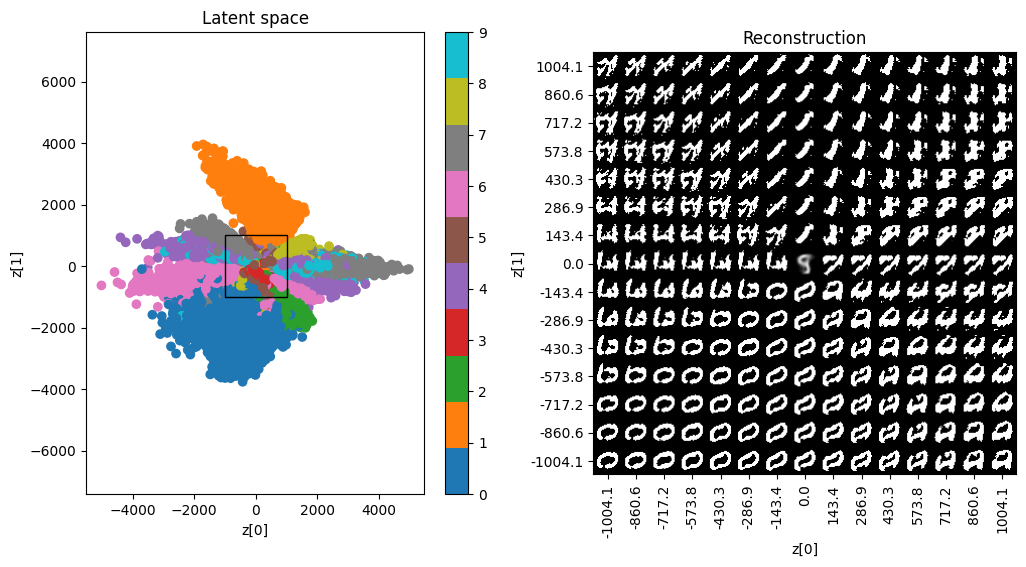

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
scale = 0.2 * np.max(np.abs(z_ae))
plot_label_clusters(fig, ax[0], z_ae, labels.numpy(), scale=scale)
ax[0].set_title("Latent space")
plot_latent_space(fig, ax[1], model_ae, scale=scale)
ax[1].set_title("Reconstruction")
plt.show()

> 📝 **Pregunta 5 (1 punto).** ¿Podríamos interpolar *correctamente* entre cualesquiera dos ejemplos y tener la certeza de que el resultado tendrá *sentido*? ¿Por qué?

> **Respuesta**: Para generar nuevos datos, el descodificador toma muestras del espacio latente. El muestreo de los puntos específicos del espacio latente que representan las entradas originales en los datos de entrenamiento replicaría esas entradas originales. Para generar nuevos datos, la **AE** debe ser capaz de tomar muestras de cualquier punto del espacio latente entre los puntos de datos originales. Para que esto sea posible, el espacio latente debe presentar dos tipos de regularidad: **Continuidad**: puntos cercanos en el espacio latente deben generar contenido similar cuando son descodificados, **Completitud:** cualquier punto muestreado del espacio latente debe generar contenido con significado al ser descodificado. Los autoencoders no distribuyen de ninguna manera los puntos en el espacio latente, de esta forma se rompe el punto de cotinuidad, por lo que la interpolación podría no tener sentido, ya que está muestreando de una región que no ha visto nunca. Si se le aplicara una restricción sobre la distribución, se podría pasar de la distribución que representa al $8$ (por ejemplo) a la del $5$ y que este resultado intermedio tuviese sentido. Es lo que hacen las **VAEs**.

> 📝 **Pregunta 6 (1 punto).** ¿Qué clases están mejor *separadas*? ¿Qué ocurriría si cambiamos la dimensión del espacio latente?

> **Respuesta**: Las que parecen mejor separadas son la clase naranjas (el $1$) y la clase azul (el $0$). El resto están más aglomeradas, de hecjo la clase cuatro no parece situarse en una región, están un poco dispersa y otras dos clases interfieren en el espacio $2D$ de el medio. Si cambiasemos la dimensión aumentándola (por ejemplo, de $2D$ a $3D$ o más) permitiría al modelo capturar más información sobre las características de los datos. Esto podría resultar en una mejor separación entre las clases, especialmente para las que se superponen actualmente.

# Autoencoder variacional

Ahora vamos a construir un Autoencoder Variacional (Variational AutoEncoder, VAE). Denotamos por $\mathbf{x}$ a las variables del espacio $\mathcal{X}$ y por $\mathbf{z}$ a las variables del espacio latente $\mathcal{Z}$. Un VAE es un modelo probabilístico, cuya distribución conjunta escribimos como
$$p(\mathbf{x}, \mathbf{z}) = p(\mathbf{z}) p(\mathbf{x} \mid \mathbf{z}).$$
La forma de las distribuciones $p(\mathbf{z})$ y $p(\mathbf{x} \mid \mathbf{z})$ las elegimos nosotros:
$$p(\mathbf{z}) = \mathcal{N}(\mathbf{z} \mid \mathbf{0}, \mathbf{I}), \quad p(\mathbf{x} \mid \mathbf{z}) = \mathcal{N}(\mathbf{x} \mid f_D(\mathbf{z}), \sigma^2 \mathbf{I}).$$
Nuestro objetivo es *codificar* las imágenes. Para ello, tenemos que conocer la distribución $p(\mathbf{z} \mid \mathbf{x})$. Sin embargo, si elegimos que $f_D$ sea una red neuronal, no sabemos calcularla de forma analítica. 

> 📝 **Pregunta 7 (1 punto).** ¿Qué forma debe de tener $f_D(\mathbf{z}$) para recuperar PPCA al ajustar los parámetros por máxima verosimilitud?

> $f_D(\mathbf{z}) = Wz+\mu+\epsilon$ donde $W$ es la matriz de pesos que mapea el espacio latente, $\mu$ es la media de los datos en el espacio observado y $\epsilon$ el ruido isotrópico *gaussiano*. Obviamente sin no linealidades, solo la fórmula descrita.

Lo que hacemos es aproximar $p(\mathbf{z} \mid \mathbf{x})$ por una distribución 
$$ q(\mathbf{z} \mid \mathbf{x}) = \mathcal{N}(\mathbf{z} \mid m_E(\mathbf{x}), \mathrm{diag}(s_E(\mathbf{x})^2),$$
donde $m_E$ y $s_E$ son redes neuronales. Podemos entender que el codificador ahora tiene la siguiente estructura:
$$ f_E(\mathbf{x}) = \left[ m_E(\mathbf{x}), s_E(\mathbf{x})^2 \right].$$


In [17]:
class VarEncoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super(VarEncoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=28 * 28, out_features=100),  # [B, 100]
            torch.nn.ReLU(),  # [B, 100]
            torch.nn.Linear(in_features=100, out_features=50),  # [B, 50]
            torch.nn.ReLU(),  # [B, 50]
        )

        self.encoder_mean = torch.nn.Sequential(
            torch.nn.Linear(in_features=50, out_features=latent_dim),  # [B, latent_dim]
        )
        self.encoder_log_var = torch.nn.Sequential(
            torch.nn.Linear(in_features=50, out_features=latent_dim),  # [B, latent_dim]
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # x: [B, 1*28*28]
        z = self.encoder(x)  # z: [B, 50]
        z_mean = self.encoder_mean(z)  # z_mean: [B, latent_dim]
        z_log_var = self.encoder_log_var(z)  # z_log_var: [B, latent_dim]
        return z_mean, z_log_var

Fíjate que ahora la salida del codificador no es un sólo "objeto", sino dos. Creamos el VAE de la misma forma que el determinista:

In [18]:
class VarAutoencoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super(VarAutoencoder, self).__init__()
        self.encoder = VarEncoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        return self.decoder(z_mean)

¿Cómo elegimos los parámetros de $f_E$ y $f_D$ para que $q(\mathbf{z} \mid \mathbf{x})$ aproxime correctamente a $p(\mathbf{z} \mid \mathbf{x})$?. Empleando el enfoque de inferencia variacional, buscamos maximizar una cota inferior sobre la verosimilitud, que se llama Evidence Lower BOund (ELBO):
$$ \sum_i \log p(\mathbf{x}_i) \geq \mathrm{ELBO}$$
Nuestra función de pérdida será entonces el ELBO con el signo cambiado:
$$ \mathcal{L} = - \mathrm{ELBO} = \mathcal{L}_{\mathrm{KL}} + \mathcal{L}_{\mathrm{MSE}}$$
donde 
$$ 
\mathcal{L}_{\mathrm{MSE}} = - \sum_{i} \mathbb{E}_{q(\mathbf{z} \mid \mathbf{x}_i)}\left[ \log p( \mathbf{x}_i \mid \mathbf{z}) \right] \approx \sum_{i} \| \mathbf{x}_i - f_D(\mathbf{z}_{i})\|^2, \quad \mathbf{z}_{i} \sim  \mathcal{N}(m_E(\mathbf{x}_i), \mathrm{diag}(s_E(\mathbf{x}_i))), \\
\mathcal{L}_{\mathrm{KL}} = \sum_{i} D_{\mathrm{KL}}(q(\mathbf{z} \mid \mathbf{x}_i), p(\mathbf{z})) = \sum_{i} \frac{1}{2}\left( \| m_E(\mathbf{x}_i) \|^2 + \| s_E(\mathbf{x}_i) \|^2 - \sum_j \log(s_E(\mathbf{x}_i)_j^2) - 1 \right).
$$

In [19]:
def kl_loss_fn(z_mean, z_log_var):
    return 0.5 * torch.sum(-1 - z_log_var + z_mean**2 + torch.exp(z_log_var))

> 📝 **Pregunta 8 (2 puntos).** Supongamos que `X` e `Y` son tensores de forma (shape) `[A, B, C, D]`. Indica qué forma tienen los tensores que devuelven las siguientes operaciones (tendrás que leer la documentación de Pytorch):
> - `torch.mse_loss(X, Y, reduction='none')`
> - `torch.sum(torch.mse_loss(X, Y, reduction='none'), dim=[2])`
> - `torch.sum(torch.mse_loss(X[0,:,:,:], Y[1,:,:,:], reduction='none'), dim=[2])`

> **Respuesta**: 
> - `torch.mse_loss(X, Y, reduction='none')` $\rightarrow$ Devuelve la misma forma, es decir, `[A,B,C,D]`, ya que solo se calcula el promedio de la diferencia entre `X` e `Y`.
> - `torch.sum(torch.mse_loss(X, Y, reduction='none'), dim=[2])` $\rightarrow$ Esta función suma los elementos de los tensores especificados. Si se le especifica una lista de dimensiones, reduce sobre estas. En este caso reduce sobre la dimensión $2$, por lo que el resultado sería de forma `[A,B,D]`.
> - `torch.sum(torch.mse_loss(X[0,:,:,:], Y[1,:,:,:], reduction='none'), dim=[2])` $\rightarrow$ En este caso ocurre lo mismo que en el segundo, lo único que cambia es que se está cogiendo de `X` solo el primer elementp de la primera dimensión con todos sus valores, de forma `[B,C,D]`, y de `Y` el segundo elemento, con igual tamaño `[B,C,D]`. Al reducir sobre la segunda dimensión, el resultado final sería de forma `[B,C]`.

Definimos el bucle para entrenar el VAE.

In [20]:
def train_vae(model, dataloader, optimizer, epochs=10):
    metrics_dic = {"rec_loss": [], "kl_loss": []}
    for epoch in range(1, epochs + 1):
        rec_loss_sum = 0
        kl_loss_sum = 0
        pbar = tqdm(enumerate(dataloader), total=len(dataloader))
        pbar.set_description(f"Epoch {epoch} - Training")
        for batch_idx, batch in pbar:
            x, _ = batch
            x = x.to(DEVICE)
            z_mean, z_log_var = model.encoder(x)
            z_sd = torch.exp(0.5 * z_log_var)
            z_sample = z_mean + z_sd * torch.randn_like(z_mean)
            x_rec = model.decoder(z_sample)
            rec_loss = mse_loss_fn(x, x_rec)
            kl_loss = kl_loss_fn(z_mean, z_log_var)
            loss = rec_loss + kl_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            rec_loss_sum += rec_loss.item()
            kl_loss_sum += kl_loss.item()
            pbar.set_postfix(
                {
                    "rec_loss": rec_loss_sum / (batch_idx + 1),
                    "kl_loss": kl_loss_sum / (batch_idx + 1),
                }
            )
        rec_loss_avg = rec_loss_sum / len(dataloader)
        kl_loss_avg = kl_loss_sum / len(dataloader)
        metrics_dic["rec_loss"].append(rec_loss_avg)
        metrics_dic["kl_loss"].append(kl_loss_avg)
    return model

> 📝 **Pregunta 9 (1 punto).** ¿Dónde estamos empleando la trampa de la reparametrización? ¿Puedes explicar qué estamos haciendo en esa línea?

> **Respuesta**: 
> `z_sd = torch.exp(0.5 * z_log_var)`
> `z_sample = z_mean + z_sd * torch.randn_like(z_mean)`
> Se está generando la variable de desviación típica a partir del logarítmo de la varianza, por eso la función exponencial. Al ser la varianza y necesitar nosotros la desviación típica (para poder muestrear) debemos multiplicar por $0.5$. Recordemos que $\sigma^2$ es la varianza y la desviación típica es $\sigma$, por tanto $\sigma=\sqrt{\sigma^2}$. En nuestro caso tenemos $log(\sqrt{\sigma^2})=0.5\cdot log(\sigma^2)$, por las propiedades de los logaritmos. Aplicando la exponencial, ya tendríamos $\sigma$.
> Luego obtenemos una muestra de distribución normal centrada en la media de $z$ y lo escalamos y movemos con la desviación y la media.


Entrenamos el VAE:

In [21]:
model_vae = VarAutoencoder(latent_dim=2).to(DEVICE)
opt = torch.optim.Adam(model_vae.parameters())
model_vae.train()
model_vae = train_vae(model_vae, dataloader, opt, epochs=EPOCHS)

Epoch 1 - Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30 - Training: 100%|██████████| 469/469 [00:04<00:00, 103.28it/s, rec_loss=3.96e+3, kl_loss=633]


> 📝 **Pregunta 10 (1 punto).** ¿Por qué el error de reconstrucción decrece mientras que la divergencia de Kullback-Leibler crece?

> **Respuesta**: La fórmula que tenemos en el código está negada con respecto a la original, de esta forma en vez de minimizarse la distancia, esta se maximiza. Un número mayor indica una menor divergencia entre distribuciones, por lo que la red neuronal se comporta correctamente.
> $$
\text{KL} = 0.5 \sum_{j=1}^J \left( -1 - \log(\sigma_j^2) + \mu_j^2 + \sigma_j^2 \right)
$$

Inspeccionamos el espacio latente del VAE. 

In [22]:
x = dataset.data.unsqueeze(1).float().to(DEVICE)
labels = dataset.targets
z_vae, _ = model_vae.encoder(x)
z_vae = z_vae.detach().cpu().numpy()

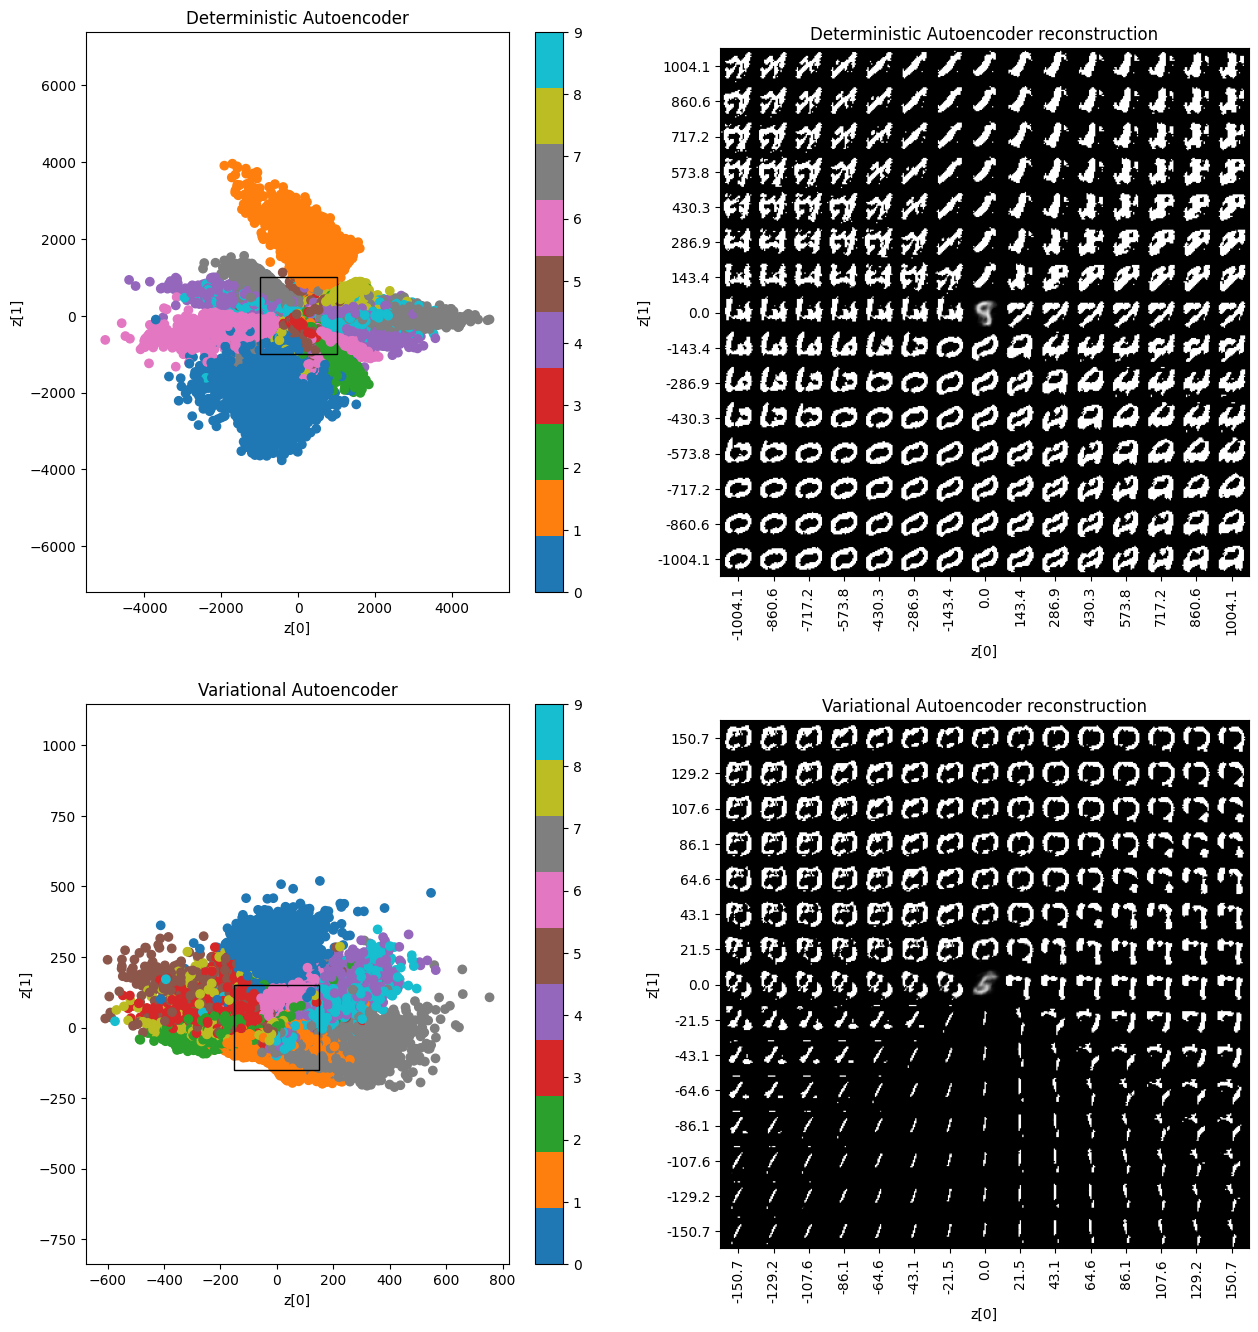

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(15, 16))
scale_ae = 0.2 * np.max(np.abs(z_ae))
scale_vae = 0.2 * np.max(np.abs(z_vae))
plot_label_clusters(fig, ax[0, 0], z_ae, labels.numpy(), scale=scale_ae)
ax[0, 0].set_title("Deterministic Autoencoder")
plot_label_clusters(fig, ax[1, 0], z_vae, labels.numpy(), scale=scale_vae)
ax[1, 0].set_title("Variational Autoencoder")
plot_latent_space(fig, ax[0, 1], model_ae, scale=scale_ae)
ax[0, 1].set_title("Deterministic Autoencoder reconstruction")
plot_latent_space(fig, ax[1, 1], model_vae, scale=scale_vae)
ax[1, 1].set_title("Variational Autoencoder reconstruction")
plt.show()

> 📝 **Pregunta 11 (1 punto).** Compara el espacio latente del Autoencoder variacional con el del Autoencoder determinista. ¿Qué ha ocurrido al incluir el término $\mathcal{L}_{\mathrm{KL}}$ en la función de pérdida? ¿Por qué es necesario incluirlo?

> **Respuesta**: Al incluirlo el espacio latente empieza a crear clusters con distribuciones similares a la normal, pues se está minimizando la divergencia entre la distribución de un cluster y la distribución normal. Es necesario ya que permite la propiedad generativa del model, ya que el descodificador aprende a asignar la distribución a priori a la distribución de los datos. Sin la regularización KL, el espacio latente no se ajustaría a una previa conocida, lo que haría ineficaz el muestreo.

El objetivo del último ejercicio es usar inferencia variacional y la trampa de la reparametrización para estimar los parámetros de un modelo PPCA muy sencillo.

Vamos a suponer que $\mathcal{X}=\mathbb{R}^2$ y $\mathcal{Z}=\mathbb{R}$. Tomamos
$$ 
p(z) = \mathcal{N}(z \mid 0, 1), \\
p(\mathbf{x} \mid z) = \mathcal{N}(\mathbf{x} \mid \mathbf{w} z, \sigma_n^2 \mathbf{I}).
$$
Observa que como estamos intentando emular un modelo PPCA tomaremos $q(z \mid \mathbf{x})=\mathcal{N}(z \mid \mathbf{m}^\top \mathbf{x}, \sigma_p^2 \mathbf{I})$ y nuestro objetivo es estimar $ \boldsymbol{\Theta} = \{ \mathbf{w}, \mathbf{m}, \sigma_p, \sigma_n\}$ para que $q(z \mid \mathbf{x})$ aproxime a $p(z \mid \mathbf{x})$.

Vamos a empezar generando las muestras. 

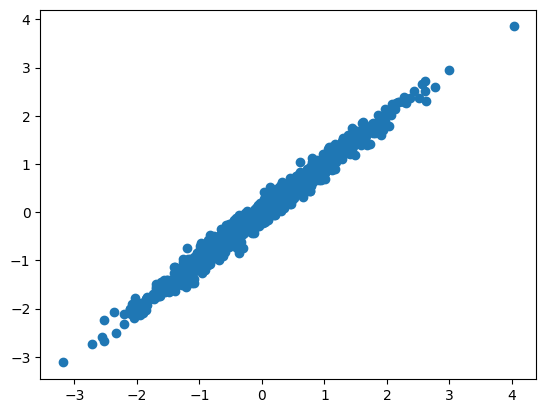

In [24]:
np.random.seed(42)
N = 1000

mean, sigma_prior = 0, 1  # Media y varianza de la a priori p(z) = N(0, 1)
Z = np.random.normal(mean, sigma_prior, N)  # N muestras de la a priori p(z)
w = np.array([[1], [1]])

sigma_n = 0.1

# Generamos muestras de la a posteriori p(x|z) = N(x|wz, sigma_noise^2 I)
X = Z * w + np.random.normal(mean, sigma_n, 2 * N).reshape(2, N)

plt.plot(X[0], X[1], "o")
plt.show()

Nuestro conjunto de entrenamiento será `X`. Observa que, si estimamos $\boldsymbol{\Theta}$ correctamente, recuperaremos los parámetros que hemos fijado para generar las muestras. 

> 📝 **Pregunta 12 (4 puntos).** Para estimar $\boldsymbol{\Theta}$ buscamos maximizar el ELBO. Esto es equivalente a minimizar el ELBO con el signo cambiado, que toma la siguiente forma:
> $$ \mathcal{L} = \sum_{i=1}^N \left[ D_{\mathrm{KL}}(q(z \mid \mathbf{x}_i), p(z)) - \mathbb{E}_{q(z \mid \mathbf{x}_i)}\left[ \log p( \mathbf{x}_i \mid z) \right] \right].$$ 
> Exprésalo como una función de los parámetros a estimar. Para el primer sumando debes usar la expresión de la Divergencia de Kullback-Leibler entre dos distribuciones normales. Para el segundo debes usar la trampa de la reparametrización. 

**Respuesta**: Para definir $\mathcal{L}$ en función de los parámetros a estimar tenemos que expresar los términos con esos parámetros:
- El término de KL $\rightarrow$ $\sum_{i}[1/2(\sigma_i^2 + \mu_i^2 - 1 - \ln(\sigma_i^2))]$. Como se expresa en los anteriores puntos definidos.
- El término de reconstrucción usando la trampa de reparametrización $\rightarrow$ $\sum_{i}[\mathbb{E}_{\varepsilon \sim \mathcal{N}(0,1)}[\log p(x_i|\mu_i + \sigma_i \cdot \varepsilon)]]$.

> 📝 **Pregunta 13 (4 puntos).** Ahora que la has expresado como una función de los parámetros a estimar, tienes que encontrar aquellos parámetros que la minimizan. Esto es lo que debes hacer en este apartado. Te ofrecemos dos alternativas:
> Alternativa (a): calcula manualmente las derivadas respecto de cada parámetro y aplica el método del gradiente descendente.
> Alternativa (b): usa las funcionalidades que ofrece Pytorch. A continuación tienes un ejemplo para minimizar la función $x \mapsto x^2 -4x + 3$.

In [29]:
import torch.optim as optim

mu = torch.randn(1, requires_grad=True)
log_sigma = torch.randn(1, requires_grad=True)

optimizer = optim.Adam([mu, log_sigma], lr=0.01)

# Example data point
x = torch.tensor(0.0)

for i in range(3000):
    optimizer.zero_grad()

    # Convert log_sigma to sigma
    sigma = torch.exp(log_sigma)

    # KL Divergence term
    kl_loss = 0.5 * (sigma**2 + mu**2 - 1 - torch.log(sigma**2))

    # Reconstruction term
    # 1. Sample from latent space using reparameterization trick
    epsilon = torch.randn(10)  # 10 samples for Monte Carlo estimation
    z_samples = mu + sigma * epsilon

    # 2. Calculate reconstruction loss using DECODER distribution
    # Assume decoder outputs N(z, 1) for this simple example
    decoder_dist = torch.distributions.Normal(z_samples, 1.0)
    recon_loss = -torch.mean(decoder_dist.log_prob(x))

    loss = kl_loss + recon_loss
    loss.backward()
    optimizer.step()

    if i % 500 == 0:
        print(f"Iteration {i}:")
        print(f"μ = {mu.item():.4f}")
        print(f"σ = {sigma.item():.4f}")
        print(f"Total loss = {loss.item():.4f}")
        print(f"KL loss = {kl_loss.item():.4f}")
        print(f"Recon loss = {recon_loss.item():.4f}\n")

print("Final values:")
print(f"μ = {mu.item():.4f}")
print(f"σ = {sigma.item():.4f}")

Iteration 0:
μ = -0.6227
σ = 1.6406
Total loss = 2.3311
KL loss = 0.5508
Recon loss = 1.7802

Iteration 500:
μ = -0.0342
σ = 0.6969
Total loss = 1.2981
KL loss = 0.1045
Recon loss = 1.1936

Iteration 1000:
μ = -0.0144
σ = 0.7015
Total loss = 1.3238
KL loss = 0.1007
Recon loss = 1.2231

Iteration 1500:
μ = -0.0072
σ = 0.6960
Total loss = 1.1563
KL loss = 0.1046
Recon loss = 1.0516

Iteration 2000:
μ = 0.0663
σ = 0.7155
Total loss = 1.2221
KL loss = 0.0932
Recon loss = 1.1289

Iteration 2500:
μ = -0.0132
σ = 0.7130
Total loss = 1.2559
KL loss = 0.0926
Recon loss = 1.1634

Final values:
μ = -0.0153
σ = 0.7031


In [25]:
x = torch.Tensor([3.0])
x.requires_grad = True
opt = torch.optim.Adam([x], lr=0.01)
for i in range(3000):
    opt.zero_grad()
    loss = x**2 - 4 * x + 3
    loss.backward()
    opt.step()
print("Final value of x:", x.item())

Final value of x: 1.999999761581421
